In [1]:
import datetime
import pytz
import glob
import re

import numpy as np
import pandas as pd

import pylab
from colour import Color
from pylab import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from bigbang import listserv
from bigbang.analysis.listserv import ListservArchive
from bigbang.analysis.listserv import ListservList
from bigbang.visualisation import stackedareachart
from bigbang.visualisation import lines
from bigbang.visualisation import utils
from bigbang.analysis.utils import (
    get_index_of_msgs_with_subject,
    get_index_of_msgs_with_datetime,
)
from bigbang.visualisation.utils import create_color_palette

In [2]:
mlist_name = "3GPP_TSG_CT_WG4"
filepath = f"path_to_bigbang/archives/3GPP/{mlist_name}.h5"  # change this to your own folder structure
df = pd.read_hdf(filepath, "df")

mlist = ListservList.from_pandas_dataframe(
    df=df,
    name=mlist_name,
    filepath=filepath,
)

mlist.df = mlist.df[mlist.df["from"].notna()]
mlist.df = mlist.df[mlist.df["comments-to"].notna()]

standard_release_info = pd.read_csv(
    "path_to_bigbang/bigbang/analysis/3GPP_standards_release_dates.csv",  # change this to your own folder structure
    sep=",",
    header=2,
    index_col=False,
)
standard_release_info["Start date"] = pd.to_datetime(
    standard_release_info["Start date"], format="%Y-%m-%d"
)
standard_release_year = [dt.year for dt in standard_release_info["Start date"]]

# Entities in Focus
eois = [
    "huawei.com",
    "huawei.comcc",
    "tencent.com",
    "xiaomi.com",
    "chinamobile.com",
    "hisilicon.comzte.com.cn",
    "chinatelecom.cn",
    "chinaunicom.cn",
    "catt.cn",
    "caict.ac.cn",
]

In [3]:
dic = {}
for eoi in eois:
    mask = []
    for index, row in mlist.df.iterrows():
        domains = []
        generator = ListservList.iterator_name_localpart_domain([row["from"]])
        for _, _, domain in generator:
            domains.append(domain)
        generator = ListservList.iterator_name_localpart_domain([row["comments-to"]])
        for _, _, domain in generator:
            domains.append(domain)
        if eoi in domains:
            mask.append(True)
        else:
            mask.append(False)

    if any(mask) is True:
        _mlist = ListservList.from_pandas_dataframe(
            df=mlist.df.loc[mask],
            name=mlist_name,
            filepath=filepath,
        )
        _dic = _mlist.get_messagescount(
            header_fields=["from", "comments-to"],
            per_address_field="localpart",
            per_year=True,
        )

        dic[eoi] = _dic

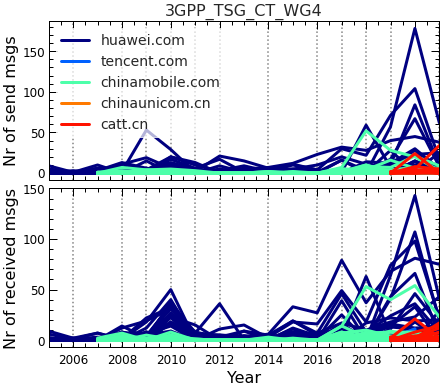

In [4]:
fig, axis = plt.subplots(
    2,
    1,
    figsize=(7, 6),
    sharex=True,
    sharey="row",
    # gridspec_kw={'height_ratios': [2, 1]},
    facecolor="w",
    edgecolor="k",
)
fig.subplots_adjust(
    hspace=0.05,
    wspace=0.0,
)

eois_colors = create_color_palette(eois, return_dict=True)
for coi in eois:
    if coi not in list(dic.keys()):
        continue

    data = dic[coi]["from"]
    x = list(data.keys())
    ylabels = stackedareachart.get_ylabels(data)
    y = stackedareachart.data_transformation(data, ylabels)
    for iy, ylab in enumerate(ylabels):
        if iy == 0:
            axis[0].plot(
                x,
                y[iy, :],
                color=eois_colors[coi],
                linewidth=3,
                label=coi,
            )
        else:
            axis[0].plot(
                x,
                y[iy, :],
                color=eois_colors[coi],
                linewidth=3,
            )

    data = dic[coi]["comments-to"]
    x = list(data.keys())
    ylabels = stackedareachart.get_ylabels(data)
    y = stackedareachart.data_transformation(data, ylabels)
    for iy, ylab in enumerate(ylabels):
        axis[1].plot(
            x,
            y[iy, :],
            color=eois_colors[coi],
            linewidth=3,
        )

for yr in standard_release_year:
    axis[0].axvline(x=yr, linestyle=":", color="k", alpha=0.5, zorder=0)
    axis[1].axvline(x=yr, linestyle=":", color="k", alpha=0.5, zorder=0)

axis[0].set_xlim(2005, 2021)
# axis[0].set_ylim(0.0, 0.49)

axis[1].set_xlim(2005, 2021)
# axis[1].set_ylim(0.0, 0.49)

axis[0].set_title(mlist_name)
axis[1].set_xlabel("Year")
axis[0].set_ylabel("Nr of send msgs")
axis[1].set_ylabel("Nr of received msgs")
axis[0].legend(loc=2, edgecolor="white", facecolor="white", framealpha=0.7)

"""
plt.savefig(
    f"uniformity_messages_coun_{mlist_name}.png",
    format='png',
    transparent=True,
    dpi=300,
    bbox_inches='tight',
)#"""